<a href="https://colab.research.google.com/github/SEOYUNJE/Lung-Image-Analysis/blob/main/Embedding/SuCon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights')
od.download('https://www.kaggle.com/datasets/seoyunje/cxr-nih-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seanbearden/tf-efficientnet-noisy-student-weights


100%|██████████| 637M/637M [00:16<00:00, 40.9MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: seoyunje
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/cxr-nih-dataset


100%|██████████| 1.86G/1.86G [00:46<00:00, 42.7MB/s]


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8)

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=5)
    
- `Strong Augment`: CutMix(patch=2)
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: None
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [2]:
!pip install -q tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [3]:
import os
import gc
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/'

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


tensorflow version:  2.15.0
Using 1 GPUs


In [4]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [6]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [70]:
USE_CXR = True

In [71]:
if USE_CXR:
    df = pd.read_csv('/content/cxr-nih-dataset/metadata.csv')
    tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', 'cxr-nih-dataset','*', '*'))}

    df['path'] = df['Image Index'].map(tmp)

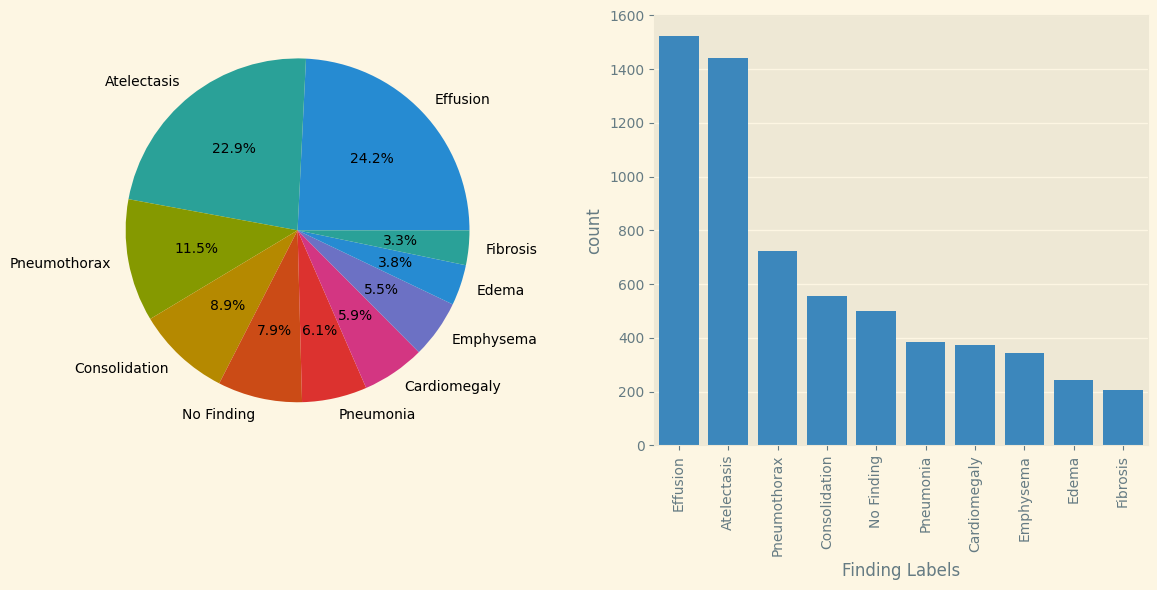

In [72]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**One Hot Encoding**

In [73]:
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)

In [78]:
for label in df['Finding Labels'].unique():
    df_test[label] = df['Finding Labels'].apply(lambda x: 1.0 if x == label else 0).astype('float32')

TARGET = df.columns[-10:]

In [79]:
TARGET

Index(['No Finding', 'Effusion', 'Cardiomegaly', 'Consolidation',
       'Atelectasis', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis',
       'Pneumonia'],
      dtype='object')

In [80]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['Finding Labels'] = label_encoder.fit_transform(df['Finding Labels'])

In [81]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build DataGenerator</b></div>

In [82]:
import albumentations as albu
print(albu.__version__)

1.4.15


In [83]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None, mode='regular'):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))


    def __len__(self):

        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),256,256,3), dtype='float32')
        if self.mode == 'regular': y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        else: y = np.zeros((len(indexes),1), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']

            img = Image.open(path).convert('L')  # Load image and convert to grayscale
            img = img.resize((256,256), Image.Resampling.LANCZOS)  # Resize image
            img = np.array(img)  # Convert PIL image to numpy array

            img = self.clahe.apply(img)  # Apply CLAHE for contrast enhancement
            img = np.expand_dims(img, axis=-1)  # Expand dimensions to make it (H, W, 1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB

            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)


            X[j,:,:,:3] = img
            if self.mode == 'regular': y[j,] = row[TARGET]
            else: y[j,] = row['Finding Labels']

        return X,y


    def __augment1(self, img_batch):

        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)

                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]

        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Build EfficientNet Model</b></div>

### install efficientnet

In [84]:
!pip install -q -U git+https://github.com/qubvel/efficientnet

import efficientnet.tfkeras as efn

  Preparing metadata (setup.py) ... done


### Encoder

In [85]:
def create_encoder():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/content/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')

    eff_out = eff_model(inp)
    x = layers.GlobalAveragePooling2D()(eff_out)

    model = Model(inputs=inp, outputs=x, name='encoder')

    return model

## Classifier

In [90]:
def create_classifier(encoder, trainable=True):
    inp = layers.Input(shape=(256,256,3))

    for layer in encoder.layers:
      layer.trainable = trainable

    features = encoder(inp)
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(features)

    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 10
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)

    model.compile(loss=loss, optimizer=opt, metrics=[AUC])

    return model

In [91]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [92]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i

In [93]:
import tensorflow.keras.backend as K

all_history = defaultdict(list)

for i in range(1):


    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        encoder = create_encoder()
        model = create_classifier(encoder)

    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        encoder.save_weights(f'regular_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])

    else:
        encoder.load_weights(f'{LOAD_MODELS_FROM}regular_f{i}.weights.h5')

    del model, encoder, train_gen, valid_gen
    gc.collect()

#########################
### Fold 1
### train size 2492, valid size 623
#########################
Epoch 1/10
156/156 [==============================] - 100s 439ms/step - loss: 0.3499 - auc: 0.7246 - val_loss: 0.3642 - val_auc: 0.7373 - lr: 0.0010
Epoch 2/10
156/156 [==============================] - ETA: 0s - loss: 0.3212 - auc: 0.7975
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
156/156 [==============================] - 68s 437ms/step - loss: 0.3212 - auc: 0.7975 - val_loss: 0.4133 - val_auc: 0.6605 - lr: 0.0010
Epoch 3/10
156/156 [==============================] - 67s 431ms/step - loss: 0.3009 - auc: 0.8492 - val_loss: 0.3152 - val_auc: 0.8211 - lr: 1.0000e-04
Epoch 4/10
156/156 [==============================] - 68s 437ms/step - loss: 0.2887 - auc: 0.8748 - val_loss: 0.3120 - val_auc: 0.8330 - lr: 1.0000e-04
Epoch 5/10
156/156 [==============================] - ETA: 0s - loss: 0.2801 - auc: 0.8893
Epoch 5: ReduceLROnPlateau reducing learning rate to

### supervised contrastive learning loss function

In [94]:
!pip install -q tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [95]:
import tensorflow_addons as tfa

In [96]:
class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [101]:
def add_projection_head(encoder):
   inp = layers.Input(shape=(256,256,3))
   features = encoder(inp)
   outputs = layers.Dense(128, activation='relu')(features)
   model = Model(inputs=inp, outputs=outputs, name='encoder_with_projection_head')
   loss = SupervisedContrastiveLoss()
   opt = optimizers.Adam(learning_rate=1e-5)

   model.compile(loss=loss, optimizer=opt)

   return model


In [98]:
projection_head = add_projection_head(create_encoder())
projection_head.summary()

Model: "encoder_with_projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder (Functional)        (None, 1280)              4049564   
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
Total params: 4213532 (16.07 MB)
Trainable params: 4171516 (15.91 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [102]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

EPOCHS = 10

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='min',verbose=1)

In [104]:
preds = []

## No TTA
train_gen = DataGenerator(df_train, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = create_encoder()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}regular_f{i}.weights.h5')
    else:
        model.load_weights(f'regular_f{i}.weights.h5')

    pred = model.predict(train_gen, verbose=1)

    preds.append(pred)
pred = np.mean(preds,axis=0)
train_embedding = pred

df_train = df_train.drop(columns=TARGET)

train_embedding = pd.DataFrame(train_embedding)
train_embedding.columns = [f'embedding_{i}' for i in range(len(train_embedding.columns))]

train_embedding = pd.concat([df_train, train_embedding], axis=1)

Fold 1
49/49 [==============================] - 68s 1s/step


In [105]:
!pip install -q umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


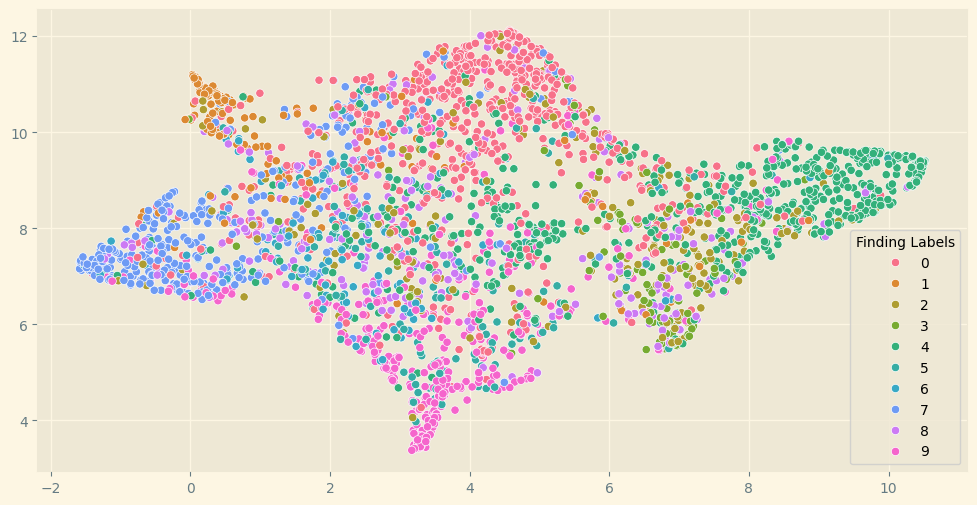

CPU times: user 39.5 s, sys: 659 ms, total: 40.2 s
Wall time: 19.8 s


In [113]:
%%time

import umap.umap_ as umap
umap = umap.UMAP()

plt.figure(figsize=(12,6))
embed_2d = umap.fit_transform(train_embedding.drop(columns=train_embedding.columns[:14]))
sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=train_embedding['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), sizes=2)

plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Contrast Learning</b></div>

In [103]:
import tensorflow.keras.backend as K

all_history = defaultdict(list)

for i in range(1):


    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=16, mode='contrast', preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, mode='contrast', preprocess=efn.preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        encoder = create_encoder()

    if LOAD_MODELS_FROM is None:
        encoder.load_weights(f'regular_f{i}.weights.h5')
        encoder_with_projection_head = add_projection_head(encoder)
        history =  encoder_with_projection_head.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        encoder.save_weights(f'contrast_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])

    else:
        encoder.load_weights(f'{LOAD_MODELS_FROM}contrast_f{i}.weights.h5')

    del encoder_with_projection_head, encoder, train_gen, valid_gen
    gc.collect()

#########################
### Fold 1
### train size 2492, valid size 623
#########################
Epoch 1/10
156/156 [==============================] - 113s 541ms/step - loss: 2.4961 - val_loss: 3.2227 - lr: 1.0000e-05
Epoch 2/10
156/156 [==============================] - 84s 541ms/step - loss: 2.4346 - val_loss: 3.2005 - lr: 1.0000e-05
Epoch 3/10
156/156 [==============================] - ETA: 0s - loss: 2.4002
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
156/156 [==============================] - 81s 520ms/step - loss: 2.4002 - val_loss: 3.1919 - lr: 1.0000e-05
Epoch 4/10
156/156 [==============================] - ETA: 0s - loss: 2.3947
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
156/156 [==============================] - 83s 531ms/step - loss: 2.3947 - val_loss: 3.1914 - lr: 1.0000e-06
Epoch 5/10
156/156 [==============================] - ETA: 0s - loss: 2.3924
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000

In [115]:

preds = []

## No TTA
train_gen = DataGenerator(df_train, shuffle=False, batch_size=64, preprocess=efn.preprocess_input, mode='contrast')

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = create_encoder()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}contrast_f{i}.weights.h5')
    else:
        model.load_weights(f'contrast_f{i}.weights.h5')

    pred = model.predict(train_gen, verbose=1)

    preds.append(pred)
pred = np.mean(preds,axis=0)
train_embedding = pred


train_embedding = pd.DataFrame(train_embedding)
train_embedding.columns = [f'embedding_{i}' for i in range(len(train_embedding.columns))]

train_embedding = pd.concat([df_train, train_embedding], axis=1)

Fold 1
49/49 [==============================] - 66s 1s/step


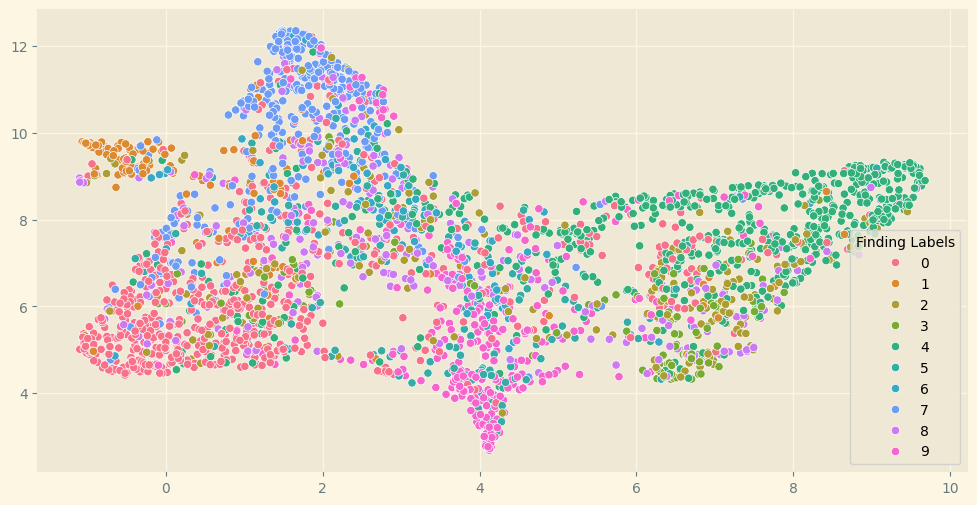

CPU times: user 31.2 s, sys: 2.34 s, total: 33.5 s
Wall time: 13.3 s


In [116]:
%%time

import umap.umap_ as umap
umap = umap.UMAP()

plt.figure(figsize=(12,6))
embed_2d = umap.fit_transform(train_embedding.drop(columns=train_embedding.columns[:14]))
sns.scatterplot(x=embed_2d[:,0], y=embed_2d[:,1], hue=train_embedding['Finding Labels'], palette=sns.color_palette("husl", n_colors=10), sizes=2)

plt.show()